**Problem Description:**

The challenge is a binary image classification task aimed at detecting metastatic cancer in small image patches extracted from larger digital pathology scans. Specifically, the goal is to develop an algorithm that can accurately classify these patches as either containing metastatic cancer (positive label) or not (negative label). The presence of cancer is determined solely by the presence of tumor tissue within the center 32x32 pixel region of each patch. This task has significant clinical relevance, as it directly addresses the critical issue of cancer metastasis detection.

**Data Description:**

The dataset is a modified version of the PatchCamelyon (PCam) benchmark dataset. It consists of a large number of small, color pathology images. Will Cukierski. Histopathologic Cancer Detection. https://kaggle.com/competitions/histopathologic-cancer-detection, 2018. Kaggle.

-   **Size:** The dataset comprises thousands of image patches, split into training and testing sets.
-   **Dimension:** Each image patch has a fixed dimension of 96x96 pixels with 3 color channels (RGB).
-   **Structure:**
    -   The data is organized into two main folders: `train` and `test`.
    -   The `train` folder contains images for training the model, and the `test` folder contains images for which predictions are to be made.
    -   A `train_labels.csv` file provides the ground truth labels for the training images, mapping image IDs to binary labels (0 or 1).
    -   The labels are only determined by the center 32x32 pixel region of each image.
    -   The outer area of the 96x96 images are provided to support fully convolutional network architectures.
-   **Format:** Images are in standard image formats (tif).
-   **Class Imbalance:** It's important to note that the dataset exhibits class imbalance, with an unequal distribution of positive and negative samples.
-   **No Duplicates:** The Kaggle version of the PCam dataset has been processed to remove duplicate images, ensuring a cleaner training set.

In [46]:
import albumentations as A
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, losses, metrics
from tensorflow.keras.applications import ResNet50, EfficientNetB3
from tensorflow.keras.layers import GlobalAveragePooling2D, Multiply
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import keras_tuner as kt
from sklearn.model_selection import train_test_split

In [47]:
# load data
train_labels = pd.read_csv('data/train_labels.csv')
train_dir = 'data/train/'
test_dir = 'data/test/'

# Display the first few rows of the labels
print(train_labels.head())

                                         id  label
0  f38a6374c348f90b587e046aac6079959adf3835      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2  755db6279dae599ebb4d39a9123cce439965282d      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4  068aba587a4950175d04c680d38943fd488d6a9d      0


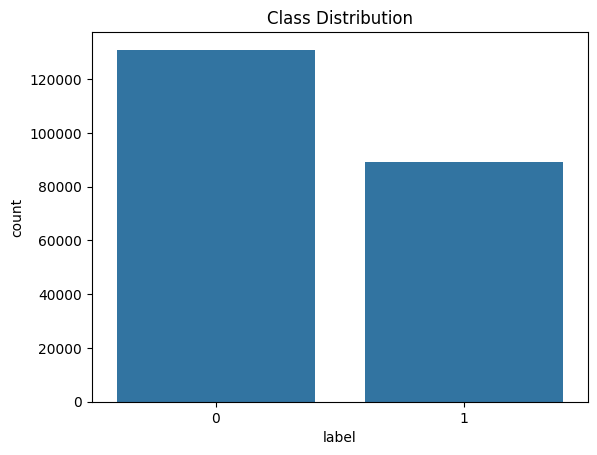

label
0    130908
1     89117
Name: count, dtype: int64


In [48]:
#  Visualizing Class Distribution

sns.countplot(x='label', data=train_labels)
plt.title('Class Distribution')
plt.show()

print(train_labels['label'].value_counts())

#### **Verify Center Region Importance**

In [57]:
# Get positive & negative samples
num_samples = 5
positive_samples = train_labels[train_labels['label'] == 1].sample(n=num_samples, random_state=42)
negative_samples = train_labels[train_labels['label'] == 0].sample(n=num_samples, random_state=42)

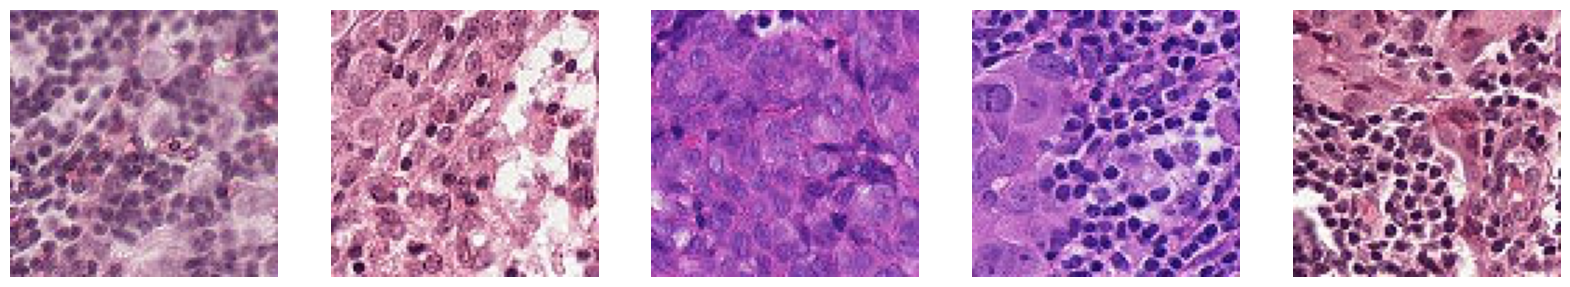

In [58]:
# Plot images, positive samples
fig, axes = plt.subplots(1, 5, figsize=(20, 4))
for ax, (idx, row) in zip(axes, positive_samples.iterrows()):
    img = cv2.imread(f'data/train/{row.id}.tif')
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    ax.imshow(img)
    ax.axis('off')
plt.show()

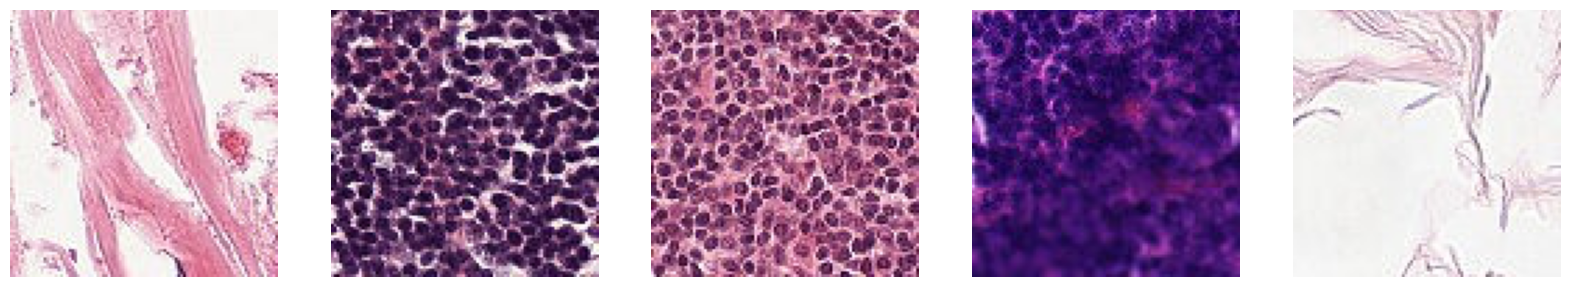

In [59]:
# Plot images, negative samples
fig, axes = plt.subplots(1, 5, figsize=(20, 4))
for ax, (idx, row) in zip(axes, negative_samples.iterrows()):
    img = cv2.imread(f'data/train/{row.id}.tif')
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    ax.imshow(img)
    ax.axis('off')

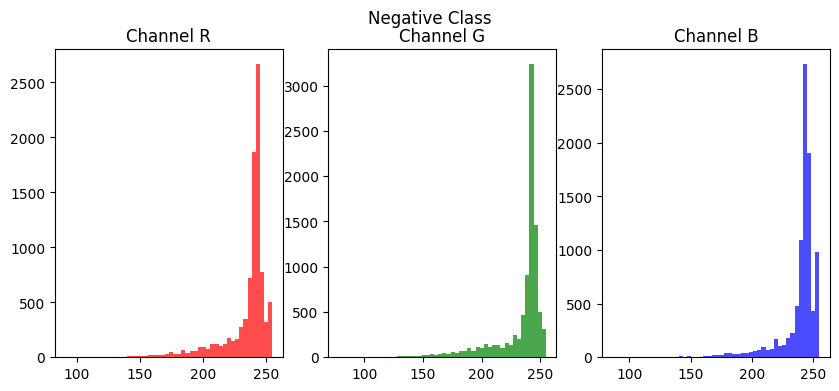

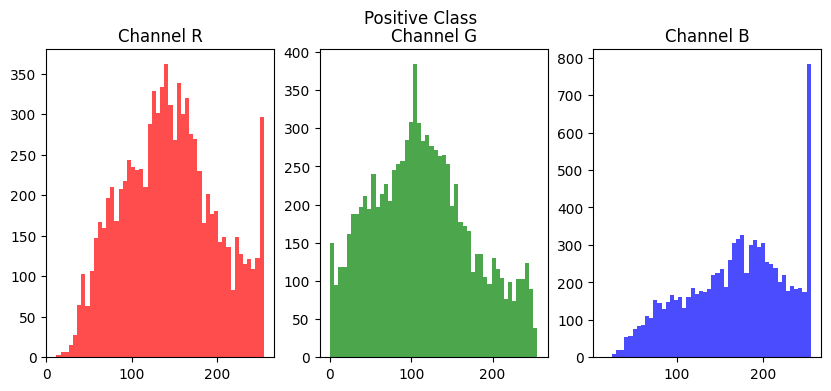

In [60]:
# Compare color histograms for positive/negative classes

def plot_color_histogram(images, title):
    plt.figure(figsize=(10, 4))
    for i in range(3):  # RGB channels
        plt.subplot(1, 3, i+1)
        plt.hist(images[..., i].ravel(), bins=50, color=['r', 'g', 'b'][i], alpha=0.7)
        plt.title(f'Channel {["R", "G", "B"][i]}')
    plt.suptitle(title)
    plt.show()

# Sample images from each class
for(idx, row) in positive_samples.iterrows():
    pos_img = cv2.imread(f'data/train/{row.id}.tif')

for (idx, row) in negative_samples.iterrows():
    neg_img = cv2.imread(f'data/train/{row.id}.tif')


plot_color_histogram(neg_img, 'Negative Class')
plot_color_histogram(pos_img, 'Positive Class')

In [61]:
# Calculate class weights for loss function

class_counts = train_labels['label'].value_counts()
total = class_counts.sum()
weight_for_0 = total / (2 * class_counts[0])  # Negative class
weight_for_1 = total / (2 * class_counts[1])  # Positive class
class_weights = {0: weight_for_0, 1: weight_for_1}
print(f"Class Weights: {class_weights}")

Class Weights: {0: 0.840380267057781, 1: 1.234472659537462}


In [54]:
train_transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5, border_mode=cv2.BORDER_CONSTANT),
    A.CLAHE(p=0.2),
])

/Users/rohangupta/Library/Python/3.9/lib/python/site-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


In [55]:
# Split data into train/validation
train_df, val_df = train_test_split(
    train_labels, 
    test_size=0.2, 
    stratify=train_labels['label'],  # Preserve class balance
    random_state=42
)
print(f"Train size: {len(train_df)}, Validation size: {len(val_df)}")

Train size: 176020, Validation size: 44005


In [62]:
# Define augmentation for training
train_datagen = ImageDataGenerator(
    preprocessing_function=lambda x: train_transform(image=x)['image'],
    rescale=1./255
)

# Validation generator (no augmentation)
val_datagen = ImageDataGenerator(rescale=1./255)

# Create generators
batch_size = 64

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory='data/train',
    x_col='id',  # Column with image filenames
    y_col='label',
    target_size=(96, 96),
    class_mode='raw',  # For raw labels (0/1)
    batch_size=batch_size,
    shuffle=True
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    directory='data/train',
    x_col='id',
    y_col='label',
    target_size=(96, 96),
    class_mode='raw',
    batch_size=batch_size,
    shuffle=False
)

Found 0 validated image filenames.
Found 0 validated image filenames.


/Users/rohangupta/Library/Python/3.9/lib/python/site-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 176020 invalid image filename(s) in x_col="id". These filename(s) will be ignored.
  warnings.warn(
/Users/rohangupta/Library/Python/3.9/lib/python/site-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 44005 invalid image filename(s) in x_col="id". These filename(s) will be ignored.
  warnings.warn(


### **Key Considerations for Architecture Design**

1.  **Focus on Center Region**:

    -   The critical diagnostic region is small (32x32 pixels), so architectures must prioritize local feature extraction over global context.

    -   Solutions: **Crop the center region** during preprocessing, use **attention mechanisms**, or design **weighted loss functions** to emphasize the center.

2.  **Class Imbalance**:

    -   Use **class weights**, **Focal Loss**, or **oversampling** to prevent bias toward the majority class.

3.  **Computational Efficiency**:

    -   96x96 images are smaller than typical ImageNet resolutions, but transfer learning with pretrained models (e.g., ResNet, EfficientNet) can still work with minor adaptations.

### **Architecture Comparison**

| **Model** | **Strengths** | **Weaknesses** | **Use Case** |
| --- | --- | --- | --- |
| **Simple CNN** | Fast, lightweight | Limited feature hierarchy | Baseline for quick testing |
| **ResNet-50 + Attention** | Strong pretrained features, dynamic focus | Computationally heavy | High-accuracy deployment |
| **EfficientNet-B3** | Efficient, scalable, good out-of-box performance | Requires tuning for medical images | Resource-constrained environments |

In [44]:
# --- Simple CNN with Center Crop ---
def build_simple_cnn():
    model = models.Sequential([
        layers.Cropping2D(cropping=((32, 32), (32, 32))),
        layers.Conv2D(32, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.GlobalAveragePooling2D(),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', 
                  metrics=[metrics.AUC(name='auc'), metrics.Recall(name='recall')])
    return model

# --- ResNet-50 + Attention ---
def build_resnet_attention():
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(96, 96, 3))
    base_model.trainable = False
    inputs = layers.Input(shape=(96, 96, 3))
    x = base_model(inputs)
    attention = layers.Conv2D(1, (1, 1), activation='sigmoid')(x)
    x = Multiply()([x, attention])
    x = GlobalAveragePooling2D()(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)
    model = models.Model(inputs, outputs)
    model.compile(optimizer=optimizers.Adam(1e-4), loss='binary_crossentropy',
                  metrics=[metrics.AUC(name='auc'), metrics.Recall(name='recall')])
    return model

# --- EfficientNet-B3 ---
def build_efficientnet():
    base_model = EfficientNetB3(weights='imagenet', include_top=False, input_shape=(96, 96, 3))
    base_model.trainable = False
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy',
                  metrics=[metrics.AUC(name='auc'), metrics.Recall(name='recall')])
    return model

# --- EfficientNet-B3 + Center Crop ---
def build_efficientnet_crop():
    model = models.Sequential([
        layers.Cropping2D(cropping=((32, 32), (32, 32))),
        EfficientNetB3(weights='imagenet', include_top=False, input_shape=(32, 32, 3)),
        layers.GlobalAveragePooling2D(),
        layers.Dense(1, activation='sigmoid')
    ])
    model.layers[1].trainable = False
    model.compile(optimizer='adam', loss='binary_crossentropy',
                  metrics=[metrics.AUC(name='auc'), metrics.Recall(name='recall')])
    return model

In [ ]:
def build_tuned_model(hp):
    base_model = EfficientNetB3(weights='imagenet', include_top=False, input_shape=(96, 96, 3))
    base_model.trainable = False
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(1, activation='sigmoid')
    ])
    # Tune learning rate and optimizer
    hp_lr = hp.Choice('learning_rate', values=[1e-3, 1e-4, 1e-5])
    hp_optimizer = hp.Choice('optimizer', values=['adam', 'sgd'])
    if hp_optimizer == 'adam':
        optimizer = optimizers.Adam(hp_lr)
    else:
        optimizer = optimizers.SGD(hp_lr, momentum=0.9)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', 
                  metrics=[metrics.AUC(name='auc')])
    return model

tuner = kt.RandomSearch(
    build_tuned_model,
    objective=kt.Objective('val_auc', direction='max'),
    max_trials=10,
    executions_per_trial=1,
    directory='tuning_dir',
    project_name='pcam'
)

# Run search (assumes you have a validation dataset)
tuner.search(train_generator, epochs=10, validation_data=val_generator)
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Best LR: {best_hps.get('learning_rate')}, Optimizer: {best_hps.get('optimizer')}")

In [ ]:
def train_model(model, train_data, val_data, epochs=20, class_weights=None):
    history = model.fit(
        train_data,
        validation_data=val_data,
        epochs=epochs,
        class_weight=class_weights,
        verbose=1
    )
    return history

# Example usage (assumes train_generator and val_generator are defined):
models = {
    'SimpleCNN': build_simple_cnn(),
    'ResNetAttn': build_resnet_attention(),
    'EfficientNet': build_efficientnet(),
    'EfficientNetCrop': build_efficientnet_crop()
}

histories = {}
for name, model in models.items():
    print(f"Training {name}...")
    histories[name] = train_model(model, train_generator, val_generator, class_weights=class_weights)

In [ ]:
def plot_history(history, title):
    plt.figure(figsize=(12, 4))
    # Loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f'{title} - Loss')
    plt.legend()
    # AUC
    plt.subplot(1, 2, 2)
    plt.plot(history.history['auc'], label='Train AUC')
    plt.plot(history.history['val_auc'], label='Val AUC')
    plt.title(f'{title} - AUC')
    plt.legend()
    plt.show()

for name, history in histories.items():
    plot_history(history, name)